In [16]:
import rqalpha as rqa
import rqalpha_plus
import rqdatac as rqd
import rqoptimizer as rqo
import datetime
import pickle
import os
import pandas as pd
from tqdm import tqdm
from result_utils import BestFactorBacktest
pd.set_option('display.width',200)
rqd.init()

F:\anaconda\envs\ricequant\lib\site-packages\rqdatac\client.py:190: UserWarning: rqdatac is already inited. Settings will be changed.
  warnings.warn("rqdatac is already inited. Settings will be changed.", stacklevel=0)


In [17]:
path = 'results'
net_value = BestFactorBacktest.get_all_net_value_df(path)

In [18]:
best_factor = BestFactorBacktest.get_best_factor(net_value,120)

In [19]:
dates = best_factor.index.levels[0].tolist()
industry = best_factor.index.levels[1].tolist()

In [20]:
interval = 20

In [21]:
def get_target_portfolio(date):
    """
    每个行业选择过去表现最好的因子当天的持仓股市值
    在行业内进行市值加权
    再乘以中证500行业权重得到最终权重
    """
    path = 'results'
    # 28个行业文件夹
    industry_list = [i for i in os.listdir(path) if os.path.splitext(i)[-1] == '.INDX']
    # 行业名称字典
    industry_name_dict = {i: rqd.instruments(i).symbol for i in industry_list}
    target_portfolio = pd.Series(dtype=np.float64)
    INDUSTRY_WEIGHT = BestFactorBacktest.get_industry_weight(date,benchmark='000905.XSHG')
    for ids in industry_list:
        industry_name = industry_name_dict[ids]
        factor = best_factor.loc[(date,industry_name)].squeeze()
        # 因子数据路径
        path1 = f'{path}/{ids}/{factor}.pkl'
        with open(path1,'rb') as pf:
            result = pickle.load(pf)
        config, backtest = result[0], result[1]
        if backtest is None:
            continue
        position = backtest['sys_analyser']['stock_positions'].loc[date,['order_book_id','market_value']]
        # 行业内市值加权
        position['weight'] = position['market_value']/position['market_value'].sum()
        ids_weight = INDUSTRY_WEIGHT[industry_name] if industry_name in INDUSTRY_WEIGHT else 0
        position = position.set_index('order_book_id')['weight']*ids_weight
        target_portfolio = target_portfolio.append(position)
    return target_portfolio.loc[lambda x:x>0]

In [22]:
target_portfolio_dict = {}
for date in dates[::interval]:
    target_portfolio = get_target_portfolio(date)
    target_portfolio_dict[date.strftime('%Y-%m-%d')] = target_portfolio

# 回测

In [23]:
def handle_bar(context, bar_dict):
    # 如果是False(不是月初),直接返回
    date = context.now.strftime('%Y-%m-%d')
    if date not in target_portfolio_dict:
        return
    print(context.now)
    print("现有持仓数:", len(context.portfolio.positions))
    context.target_portfolio = target_portfolio_dict[date]
    rebalance(context, bar_dict)


def rebalance(context, bar_dict):
    # 先清空不在目标组合里面的股票
    positions = context.portfolio.positions
    for order_book_id in positions:
        if order_book_id not in context.target_portfolio:
            rqa.api.order_to(order_book_id, 0)

    # 对每个股票计算目标价值和当前价值的差值
    # 差值为正的是买单, 反之为卖单
    capital = context.portfolio.total_value * (1 - context.cash_cushion)
    to_sell, to_buy = {}, {}
    _money_for_one_lot = lambda order_book_id: bar_dict[order_book_id].close * 100
    for order_book_id, weight in context.target_portfolio.items():
        # 股票目标价值
        target_value = capital * weight
        # 目标和现有之差
        gap = target_value - positions[order_book_id].market_value
        # 买卖至少大于1手股票价值
        if abs(gap) < _money_for_one_lot(order_book_id):
            continue
        elif gap > 0:
            to_buy[order_book_id] = gap
        else:
            to_sell[order_book_id] = gap

    # to avoid liquidity issue, sell first, buy second
    for order_book_id, value in to_sell.items():
        rqa.api.order_value(order_book_id, value)
    for order_book_id, value in to_buy.items():
        rqa.api.order_value(order_book_id, value)


In [24]:
config = {
    "base": {
        "start_date": '2014-03-01',
        "end_date": '2020-08-24',
                    "frequency": '1d',
                    "accounts": {"stock": 1e8},
                    "data_bundle_path": r'C:\Users\Administrator\.rqalpha-plus\bundle'
    },
    "mod": {
        "sys_analyser": {
            "enabled": True,
            "plot": True,
            "benchmark": '000905.XSHG',
        },
    },
    "extra": {
        "log_level": 'error',
        "context_vars": {
            'cash_cushion': 0.005,
        },
    },
}

F:\anaconda\envs\ricequant\lib\site-packages\rqdatac\client.py:190: UserWarning: rqdatac is already inited. Settings will be changed.
  warnings.warn("rqdatac is already inited. Settings will be changed.", stacklevel=0)
[2014-08-22 15:00:00.000000] INFO: user_log: 2014-08-22 15:00:00
[2014-08-22 15:00:00.000000] INFO: user_log: 现有持仓数: 0
[2014-09-22 15:00:00.000000] INFO: user_log: 2014-09-22 15:00:00
[2014-09-22 15:00:00.000000] INFO: user_log: 现有持仓数: 226
[2014-10-27 15:00:00.000000] INFO: user_log: 2014-10-27 15:00:00
[2014-10-27 15:00:00.000000] INFO: user_log: 现有持仓数: 241
[2014-11-24 15:00:00.000000] INFO: user_log: 2014-11-24 15:00:00
[2014-11-24 15:00:00.000000] INFO: user_log: 现有持仓数: 230
[2014-12-22 15:00:00.000000] INFO: user_log: 2014-12-22 15:00:00
[2014-12-22 15:00:00.000000] INFO: user_log: 现有持仓数: 241
[2015-01-21 15:00:00.000000] INFO: user_log: 2015-01-21 15:00:00
[2015-01-21 15:00:00.000000] INFO: user_log: 现有持仓数: 250
[2015-02-25 15:00:00.000000] INFO: user_log: 2015-02-25 

[2020-01-21 15:00:00.000000] INFO: user_log: 2020-01-21 15:00:00
[2020-01-21 15:00:00.000000] INFO: user_log: 现有持仓数: 358
[2020-02-26 15:00:00.000000] INFO: user_log: 2020-02-26 15:00:00
[2020-02-26 15:00:00.000000] INFO: user_log: 现有持仓数: 339
[2020-03-25 15:00:00.000000] INFO: user_log: 2020-03-25 15:00:00
[2020-03-25 15:00:00.000000] INFO: user_log: 现有持仓数: 334
[2020-04-23 15:00:00.000000] INFO: user_log: 2020-04-23 15:00:00
[2020-04-23 15:00:00.000000] INFO: user_log: 现有持仓数: 333
[2020-05-26 15:00:00.000000] INFO: user_log: 2020-05-26 15:00:00
[2020-05-26 15:00:00.000000] INFO: user_log: 现有持仓数: 338
[2020-06-23 15:00:00.000000] INFO: user_log: 2020-06-23 15:00:00
[2020-06-23 15:00:00.000000] INFO: user_log: 现有持仓数: 350
[2020-07-23 15:00:00.000000] INFO: user_log: 2020-07-23 15:00:00
[2020-07-23 15:00:00.000000] INFO: user_log: 现有持仓数: 355
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\mod\rqalpha_mod_sys_analyser\plot.py:188: UserWarning: FixedFormatter should only be used together w

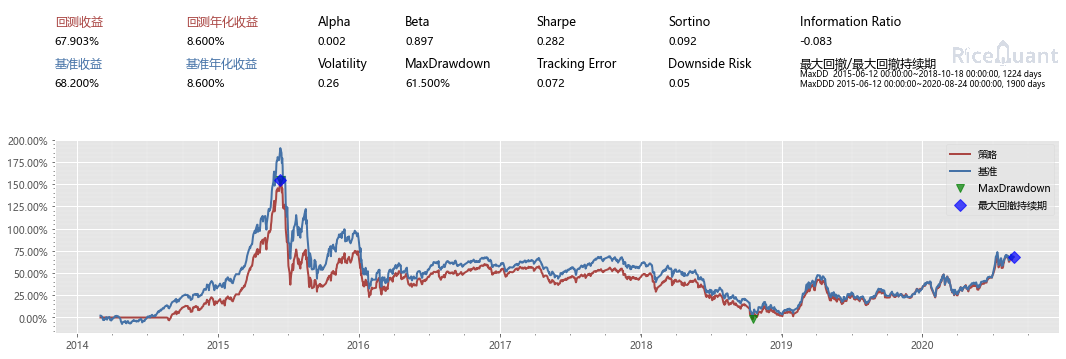

In [25]:
backtest_result = rqalpha_plus.run_func(handle_bar=handle_bar,config=config)